# Batch Inference

In [1]:
import pandas as pd
import hopsworks
import joblib
import datetime
from datetime import datetime
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
import seaborn as sns
import datetime
from sklearn.metrics import classification_report

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.
Connection closed.
Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196773
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
mr = project.get_model_registry()
model = mr.get_model("heart_model", version=1)
model_dir = model.download()
model = joblib.load(model_dir + "/heart_model.pkl")
scaler = joblib.load(model_dir + "/heart_scaler.pkl")

Connected. Call `.close()` to terminate connection gracefully.


In [5]:
HOURS = 24

In [6]:
fg = fs.get_feature_group(name="heart", version=1)
df = fg.read()

# sort by timestamp
df = df.sort_values(by=['timestamp'], ascending=False)

# get last HOURS of data based on timestamp
start_date = (datetime.datetime.now() - datetime.timedelta(hours=HOURS))
end_date = (datetime.datetime.now())

df['timestamp'] = pd.to_datetime(df.timestamp).dt.tz_localize(None)
df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
timestamp = df['timestamp']
df = df.drop(['timestamp'], axis=1)

y_true = df['heartdisease']
df = df.drop(['heartdisease'], axis=1)

y_pred = model.predict(scaler.transform(df))

Finished: Reading data from Hopsworks, using ArrowFlight (11.72s) 


In [7]:
y_pred = model.predict(scaler.transform(df))

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     73552
         1.0       0.85      1.00      0.92      6903

    accuracy                           0.99     80455
   macro avg       0.93      0.99      0.96     80455
weighted avg       0.99      0.99      0.99     80455



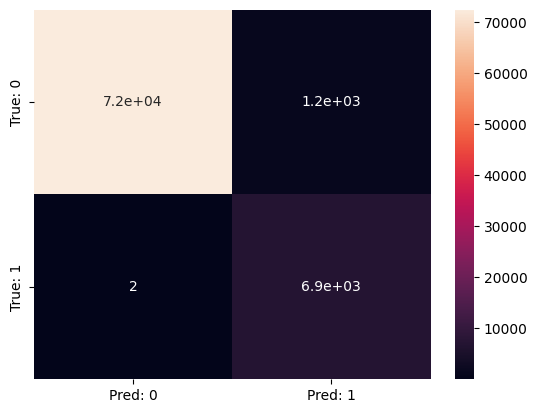

In [10]:
conf_matrix = confusion_matrix(y_true, y_pred)
true_cols = ['True: ' + str(col) for col in ["0", "1"]]
pred_cols = ['Pred: ' + str(col) for col in ["0", "1"]]
df_cm = pd.DataFrame(conf_matrix, true_cols, pred_cols)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()
fig.savefig("./confusion_matrix_heart.png") 

In [11]:
dataset_api = project.get_dataset_api()
dataset_api.upload("./confusion_matrix_heart.png", "Resources/images", overwrite=True)


Uploading: 0.000%|          | 0/18373 elapsed<00:00 remaining<?

'Resources/images/confusion_matrix_heart.png'